A Notebook for processing experimental results.

All runs correspond to a folder in `outputs/` from which we can load config information and results from json data.

In [ ]:
#outputs_folder = 'outputs'
#outputs_folder = 'outputs-llama3.1-8b'
#outputs_folder = 'outputs-llama3.1-8b-instruct'
outputs_folder = 'outputs.synt-hp'
#outputs_folder = 'outputs-qwen2.5-7b'

In [2]:
import json
from pathlib import Path
import pandas as pd

In [3]:
# Set this to filter runs based on the cfg.experiment_name argument
experiment_name = None

# It can be a list like this:
# experiment_name = ["pythia-small", "pythia-big"]

In [4]:
def load_experiment_data(experiment_name=None, base_folder="outputs"):
    """
    Load experiment data from JSON files and return a processed DataFrame.
    
    Args:
        experiment_name (str or list, optional): Name(s) of experiment(s) to filter for.
                                               If None, loads all experiments.
        base_folder (str, optional): Base path containing experiment outputs.
                                   Defaults to "outputs".
    
    Returns:
        pandas.DataFrame: Processed DataFrame containing experiment results
    """
    from pathlib import Path
    import json
    import pandas as pd
    
    folder_path = Path(base_folder)
    json_list = []
    
    # Convert single experiment name to list for consistent processing
    if isinstance(experiment_name, str):
        experiment_name = [experiment_name]
    
    # Iterate through all JSON files in subdirectories
    for json_file in folder_path.glob("*/*.json"):
        with open(json_file, "r", encoding="utf-8") as f:
            try:
                # Load the JSON content
                json_content = json.load(f)
                
                # Filter by experiment name if specified
                if experiment_name is not None:
                    if ("cfg_experiment_name" in json_content and 
                        json_content["cfg_experiment_name"] in experiment_name):
                        json_list.append(json_content)
                else:
                    json_list.append(json_content)
            except json.JSONDecodeError:
                print(f"Warning: Could not parse JSON file: {json_file}")
                continue
    
    if not json_list:
        raise ValueError(f"No data found for experiment(s): {experiment_name}")
    
    # Sort by time, increasing
    json_list = sorted(json_list, key=lambda x: x["time"])
    
    # Convert to DataFrame
    df = pd.DataFrame(json_list)
    
    # Add derived columns
    df["ratio"] = df["target_length"] / df["num_free_tokens"]
    df["memorized"] = df["ratio"] > 1
    df.loc[df["success"] == False, "memorized"] = False
    
    # Sort by multiple columns
    df = df.sort_values(by=["cfg_model_name", "cfg_dataset", 
                           "cfg_data_idx", "cfg_discrete_optimizer"])
    
    df.head().round(2)
    return df

In [5]:
df = load_experiment_data(experiment_name=experiment_name, base_folder=outputs_folder)
# print the full dataframe (without ... truncation)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df


ValueError: No data found for experiment(s): None

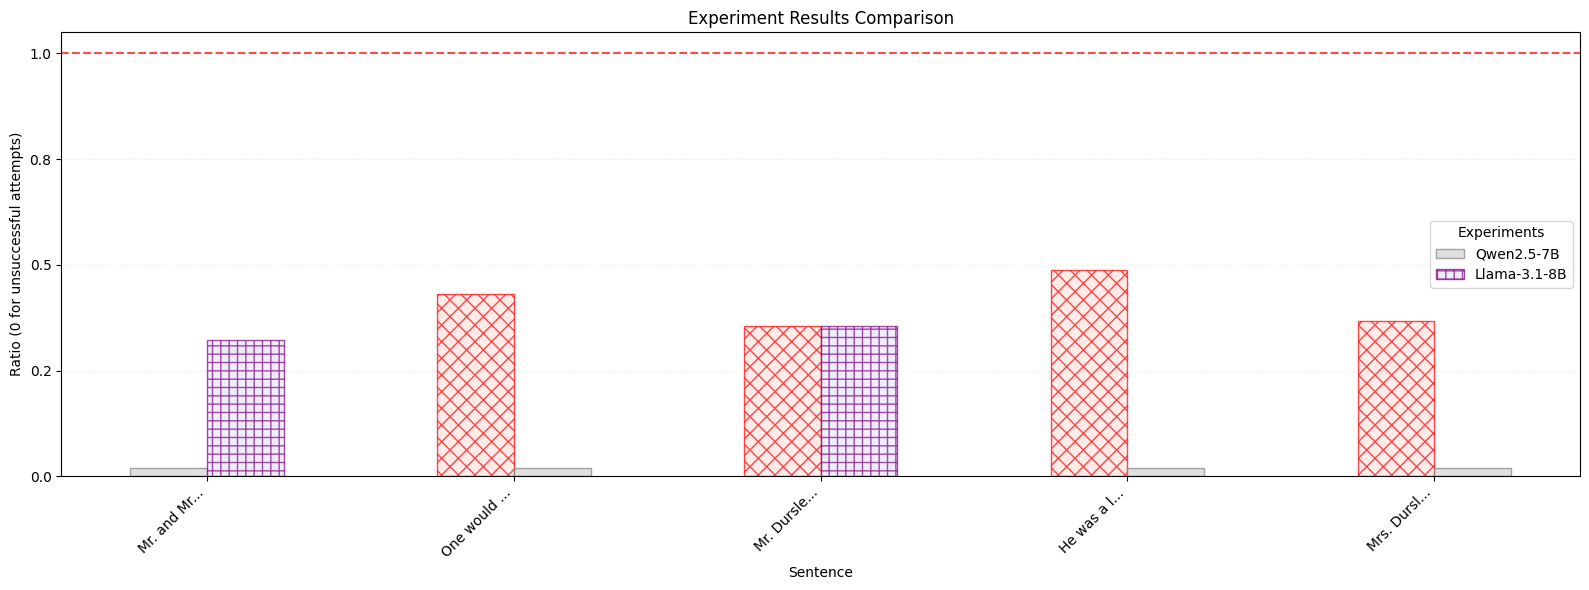

In [ ]:
def plot_experiment_results(df):
    """
    Plot ratio values as narrow hatched bars for multiple experiments with reduced spacing.
    Special handling for 10-5-1 (green) and 10-2-1 (blue) experiments.
    Failed tests (ratio=0) are shown as small sliver bars.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    def get_experiment_label(exp_name):
        """Extract label from experiment name."""
        if "10-5-1" in exp_name:
            return "10-5-1"
        elif "10-2-1" in exp_name:
            return "10-2-1"
        else:
            # Get last path component and extract text before "_gcg"
            last_component = exp_name.split('/')[-1]
            label = last_component.split('_gcg')[0]
            return label
    
    # Get unique experiments
    experiments = df['cfg_experiment_name'].unique()
    
    # Sort experiments to ensure 10-5-1 and 10-2-1 are at the end
    def sort_key(exp):
        if "10-5-1" in exp:
            return 2
        elif "10-2-1" in exp:
            return 3
        return 1
    
    experiments = sorted(experiments, key=sort_key)
    n_experiments = len(experiments)
    
    # Define base styles for other experiments
    base_styles = [
        {'hatch': 'xx', 'edge': 'red', 'face': 'mistyrose'},
        {'hatch': '++', 'edge': 'purple', 'face': 'lavender'},
        {'hatch': '--', 'edge': 'orange', 'face': 'bisque'}
    ]
    
    # Create style mapping
    styles = {}
    base_idx = 0
    
    for exp in experiments:
        if "10-5-1" in exp:
            styles[exp] = {'hatch': '//', 'edge': 'green', 'face': 'lightgreen'}
        elif "10-2-1" in exp:
            styles[exp] = {'hatch': '\\\\', 'edge': 'blue', 'face': 'lightblue'}
        else:
            styles[exp] = base_styles[base_idx % len(base_styles)]
            base_idx += 1
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Width settings
    bar_width = 0.01
    group_spacing = 0.04
    sliver_height = 0.02  # Height for failed test indicators
    
    # Legend handles
    legend_handles = []
    
    # Find max points and collect target strings
    max_points = 0
    all_target_strs = []
    
    for experiment in experiments:
        exp_df = df[df['cfg_experiment_name'] == experiment].sort_values('time')
        max_points = max(max_points, len(exp_df))
        all_target_strs.extend(exp_df['target_str'].tolist())
    
    # Create labels
    unique_targets = pd.unique(all_target_strs)
    labels = [str(s)[:10] + "..." for s in unique_targets]
    
    # Plot each experiment
    for i, experiment in enumerate(experiments):
        exp_df = df[df['cfg_experiment_name'] == experiment].sort_values('time')
        ratios = [row.ratio if row.success else 0 for _, row in exp_df.iterrows()]
        
        # Calculate positions
        x = np.arange(len(ratios)) * group_spacing
        offset = (i - n_experiments/2 + 0.5) * bar_width
        x_positions = x + offset
        
        # Get style for this experiment
        style = styles[experiment]
        
        # Get label for this experiment
        label = get_experiment_label(experiment)
        
        # Plot bars for each ratio
        bars = []
        for j, (ratio, success) in enumerate(zip(ratios, exp_df['success'])):
            if success:
                # Normal bar for successful tests
                bar = ax.bar(x_positions[j], ratio,
                           width=bar_width,
                           hatch=style['hatch'],
                           alpha=0.7,
                           edgecolor=style['edge'],
                           color=style['face'],
                           label=label if j == 0 else "")
                bars.append(bar[0])
            else:
                # Sliver bar for failed tests - using experiment colors
                bar = ax.bar(x_positions[j], sliver_height,
                           width=bar_width,
                           hatch=style['hatch'],
                           alpha=0.7,
                           edgecolor=style['edge'],
                           color=style['face'],
                           label=label if j == 0 else "")
                bars.append(bar[0])
        
        legend_handles.append(bars[0])
    
    # Add horizontal line at 1.0
    ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7)
    
    # Set y-axis ticks
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    # Customize plot
    ax.set_title("Experiment Results Comparison", fontsize=12)
    ax.set_xlabel('Sentence', fontsize=10)
    ax.set_ylabel('Ratio (0 for unsuccessful attempts)', fontsize=10)
    
    # Add legend
    ax.legend(title="Experiments")
    
    # Set x-axis labels
    plt.xticks(np.arange(max_points) * group_spacing, labels[:max_points], rotation=45, ha='right')
    
    # Add grid
    ax.grid(True, axis='y', linestyle=':', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

plt = plot_experiment_results(df)
plt.show()

# save to outputs folder
plt.savefig(f"{outputs_folder}/experiment_results.png")

In [ ]:
# Filter the rows where dataset is 'random', the model is 'EleutherAI/pythia-14m', and success is True
filtered_df = df[(df['cfg_dataset'] == 'famous_quotes') &
                 (df['cfg_model_name'] == 'EleutherAI/pythia-14m')
                 ]
filtered_df.head().round(2)

,target_length,target_str,loss_of_target_str,loss_of_prompt,success,optimal_prompt,free_token_slice,input_slice,target_slice,loss_slice,num_free_tokens,input_ids,cfg_batch_size,cfg_chat_template,cfg_use_binary_search,cfg_data_idx,cfg_dataset,cfg_discrete_optimizer,cfg_experiment_name,cfg_input_str,cfg_lr,cfg_max_tokens,cfg_mini_batch_size,cfg_model_name,cfg_num_steps,cfg_optimizer,cfg_random_weights,cfg_run_id,cfg_seed,cfg_system_prompt,cfg_target_str,cfg_topk,time,ratio,memorized


In [ ]:
# Sort and dedup
df_sorted = df.sort_values(by=['cfg_model_name', 'cfg_discrete_optimizer', 'cfg_dataset', 'cfg_data_idx', 'success'], ascending=[True, True, True, True, False])
df = df_sorted.drop_duplicates(subset=['cfg_dataset', 'cfg_data_idx', 'cfg_model_name', 'cfg_discrete_optimizer'], keep='first')
df = df[df["success"] == True]

# Make summary counting the average ratio and success rate for each dataset and discrete_optimizer include counts
summary = df.groupby(["cfg_model_name", "cfg_dataset", "cfg_discrete_optimizer"]).agg(
    {"ratio": "mean", "memorized": "mean", "success": "count"}).round(2)
summary

,,,ratio,memorized,success
cfg_model_name,cfg_dataset,cfg_discrete_optimizer,,,
Qwen/Qwen2.5-7B,obliviate-neg,gcg,0.41,0.0,4
meta-llama/Llama-3.1-8B,obliviate-neg,gcg,0.34,0.0,2
